<a href="https://colab.research.google.com/github/DLSeed/DeepLearning/blob/main/image_2_image_using_diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image2Image pipeline for Stabel Diffusion using d🧨ffusers 

This notebook shows how to create a custom `diffusers` pipeline for  text-guided image-to-image generation with Stable Diffusion model using  🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers). 

For a general introduction to the Stabel Diffusion model please refer to this [colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).



In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
!pip install -qq -U diffusers transformers ftfy
!pip install -qq "ipywidgets>=7,<8"

     |████████████████████████████████| 112 kB 6.8 MB/s 
     |████████████████████████████████| 4.7 MB 58.9 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 120 kB 75.0 MB/s 
     |████████████████████████████████| 6.6 MB 55.4 MB/s 
     |████████████████████████████████| 1.6 MB 8.0 MB/s 


You need to accept the model license before downloading or using the weights. In this post we'll use model version `v1-4`, so you'll need to  visit [its card](https://huggingface.co/CompVis/stable-diffusion-v1-4), read the license and tick the checkbox if you agree. 

You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work. For more information on access tokens, please refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).

In [3]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


## Image2Image pipeline.

In [5]:
import inspect
import warnings
from typing import List, Optional, Union

import torch
from torch import autocast
from tqdm.auto import tqdm

from diffusers import (
    AutoencoderKL,
    DDIMScheduler,
    DiffusionPipeline,
    PNDMScheduler,
    UNet2DConditionModel,
)
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer


Define the pipeline for image2image

In [116]:
class StableDiffusionImg2ImgPipeline(DiffusionPipeline):
    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        tokenizer: CLIPTokenizer,
        unet: UNet2DConditionModel,
        scheduler: Union[DDIMScheduler, PNDMScheduler],
        safety_checker: StableDiffusionSafetyChecker,
        feature_extractor: CLIPFeatureExtractor,
    ):
        super().__init__()
        scheduler = scheduler.set_format("pt")
        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
            safety_checker=safety_checker,
            feature_extractor=feature_extractor,
        )

    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]],
        init_image: torch.FloatTensor,
        strength: float = 0.8,
        num_inference_steps: Optional[int] = 200, #50,
        guidance_scale: Optional[float] = 7.5,
        eta: Optional[float] = 0.0,
        generator: Optional[torch.Generator] = None,
        output_type: Optional[str] = "pil",
    ):

        if isinstance(prompt, str):
            batch_size = 1
        elif isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

        if strength < 0 or strength > 1:
          raise ValueError(f'The value of strength should in [0.0, 1.0] but is {strength}')

        # set timesteps
        accepts_offset = "offset" in set(inspect.signature(self.scheduler.set_timesteps).parameters.keys())
        extra_set_kwargs = {}
        offset = 0
        if accepts_offset:
            offset = 1
            extra_set_kwargs["offset"] = 1

        self.scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)

        # encode the init image into latents and scale the latents
        init_latents = self.vae.encode(init_image.to(self.device)).sample()
        init_latents = 0.18215 * init_latents

        # prepare init_latents noise to latents
        init_latents = torch.cat([init_latents] * batch_size)
        
        # get the original timestep using init_timestep
        init_timestep = int(num_inference_steps * strength) + offset
        init_timestep = min(init_timestep, num_inference_steps)
        timesteps = self.scheduler.timesteps[-init_timestep]
        timesteps = torch.tensor([timesteps] * batch_size, dtype=torch.long, device=self.device)
        
        # add noise to latents using the timesteps
        noise = torch.randn(init_latents.shape, generator=generator, device=self.device)
        init_latents = self.scheduler.add_noise(init_latents, noise, timesteps)

        # get prompt text embeddings
        text_input = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = self.text_encoder(text_input.input_ids.to(self.device))[0]

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0
        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            max_length = text_input.input_ids.shape[-1]
            uncond_input = self.tokenizer(
                [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
            )
            uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = torch.cat([uncond_embeddings, text_embeddings])


        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]
        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        latents = init_latents
        t_start = max(num_inference_steps - init_timestep + offset, 0)
        for i, t in tqdm(enumerate(self.scheduler.timesteps[t_start:])):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents

            # predict the noise residual
            noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs)["prev_sample"]

        # scale and decode the image latents with vae
        latents = 1 / 0.18215 * latents
        image = self.vae.decode(latents)

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()

        # run safety checker
        safety_cheker_input = self.feature_extractor(self.numpy_to_pil(image), return_tensors="pt").to(self.device)
        image, has_nsfw_concept = self.safety_checker(images=image, clip_input=safety_cheker_input.pixel_values)

        if output_type == "pil":
            image = self.numpy_to_pil(image)

        return {"sample": image, "nsfw_content_detected": has_nsfw_concept}

Load the pipeline

In [117]:
device = "cuda"
model_path = "CompVis/stable-diffusion-v1-4"

# Using DDIMScheduler as anexample,this also works with PNDMScheduler
# uncomment this line if you want to use it.

# scheduler = PNDMScheduler.from_config(model_path, subfolder="scheduler", use_auth_token=True)

scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_path,
    scheduler=scheduler,
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)



In [118]:
def dummy_checker(images, **kwargs): return images, False
pipe.safety_checker = dummy_checker

Download an initial image and preprocess it so we can pass it to the pipeline.

In [11]:
import PIL
from PIL import Image
import numpy as np

def preprocess(image):
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.

In [ ]:
import requests
from io import BytesIO
import os
from google.colab import drive
drive.mount('/home',force_remount=True)

url = "../content/sample_data/71845547.jpg"#"https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

#response = requests.get(url)
#init_img = Image.open(BytesIO(response.content)).convert("RGB")
init_img = Image.open(url).convert("RGB")
init_img = init_img.resize((704, 512))
init_img

Preprocess the image.

In [119]:
init_image = preprocess(init_img)

Define the prompt and run the pipeline.

In [132]:
prompt = "A japanese girl with no clothes running on street at night, artstation" #"A fantasy landscape, trending on artstation"

Here, `strength` is a value between 0.0 and 1.0, that controls the amount of noise that is added to the input image. Values that approach 1.0 allow for lots of variations but will also produce images that are not semantically consistent with the input.

In [ ]:
generator = torch.Generator(device=device).manual_seed(1024)
with autocast("cuda"):
    images = pipe(prompt=prompt, init_image=init_image, strength=0.95, guidance_scale=7.5, generator=generator)["sample"]

0it [00:00, ?it/s]

In [ ]:
images[0]

# 新段落

# 新段落

In [ ]:
with autocast("cuda"):
    images = pipe(prompt=prompt, init_image=init_image, strength=0.5, guidance_scale=7.5, generator=generator)["sample"]

0it [00:00, ?it/s]

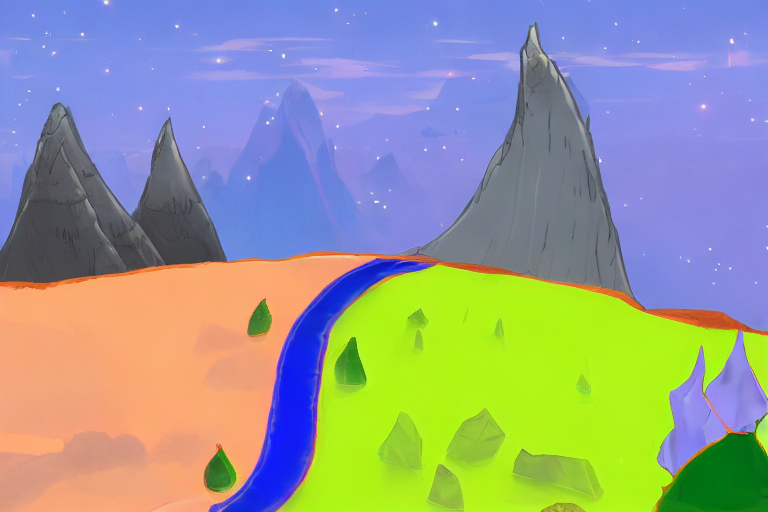

In [ ]:
images[0]

As you can see, when using a lower value for `strength`, the generated image is more closer to the original `init_image`

Using PNDMScheduler (PLMS).

In [247]:
scheduler = PNDMScheduler.from_config(model_path, subfolder="scheduler", use_auth_token=True)
pipe.scheduler = scheduler

In [252]:
generator = torch.Generator(device=device).manual_seed(4096)
with autocast("cuda"):
    images = pipe(prompt=prompt, init_image=init_image, strength=0.3, guidance_scale=7.5, generator=generator)["sample"]

0it [00:00, ?it/s]

In [ ]:
images[0]